In [1]:
import random
import time
import timeit
import numpy as np
import pandas as pd
import cv2
import matplotlib.pyplot as plt
from pylab import rcParams
rcParams['figure.figsize'] = 12,7
import warnings
warnings.filterwarnings('ignore')
from tqdm.notebook import tqdm
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Dropout, Flatten
from tensorflow.keras import backend as K
from tensorflow.keras import initializers
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.datasets import mnist, cifar10, fashion_mnist
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import *
import torch
import torch.nn as nn
import torch.optim as optim
import tempfile
from torch.utils.data import Dataset, DataLoader, TensorDataset

In [2]:
!python --version

Python 3.7.11


In [3]:
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [26]:
if tf.test.gpu_device_name():
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))
else:
    print("Please install GPU version of TF")

Default GPU Device: /device:GPU:0


# 2.1

## Summary of FashionMNIST dataset

Dataset size: 70000 \\
Training set size: 60000 \\
Validation set size: 10000 \\
Number of classes: 10 \\
Number of images per class: 6000

More specific information is given below


In [4]:
(X_train, Y_train), (X_test, Y_test) = fashion_mnist.load_data()
X_train.shape, X_test.shape, Y_train.shape, Y_test.shape

((60000, 28, 28), (10000, 28, 28), (60000,), (10000,))

In [5]:
class_names = ["top", "trouser", "pullover", "dress", "coat",
              "sandal", "shirt", "sneaker", "bag", "ankle boot"]
print("No.of classes: ", len(np.unique(Y_train)))
print("\nTraining Data:")
for i in range(10):
    print("{}: {}".format(class_names[i], sum(Y_train == i)))
print("\nTest Data")
for i in range(10):
    print("{}: {}".format(class_names[i], sum(Y_test == i)))

No.of classes:  10

Training Data:
top: 6000
trouser: 6000
pullover: 6000
dress: 6000
coat: 6000
sandal: 6000
shirt: 6000
sneaker: 6000
bag: 6000
ankle boot: 6000

Test Data
top: 1000
trouser: 1000
pullover: 1000
dress: 1000
coat: 1000
sandal: 1000
shirt: 1000
sneaker: 1000
bag: 1000
ankle boot: 1000


Classes:  ['trouser', 'pullover', 'dress']


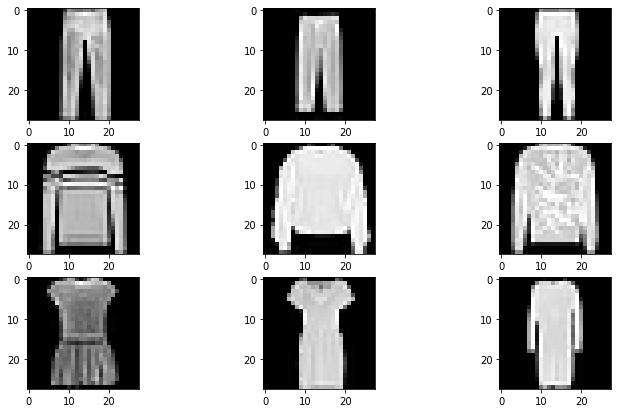

In [6]:
idxs = []
idxs.extend(np.where(Y_train==1)[0][:3])
idxs.extend(np.where(Y_train==2)[0][:3])
idxs.extend(np.where(Y_train==3)[0][:3])
class_lst = class_names[1:4]
print("Classes: ", class_lst)
for i in range(9):
    plt.subplot(3,3,i+1)
    plt.imshow(X_train[idxs[i]], cmap='gray')
plt.show()

# 2.2


In [7]:
BATCH_SIZE = 64
N_EPOCHS = 5
lrs = [10**(-i) for i in range(9,-2,-1)]
lrs

[1e-09, 1e-08, 1e-07, 1e-06, 1e-05, 0.0001, 0.001, 0.01, 0.1, 1, 10]

In [8]:
X_train = np.array([cv2.resize(x, (32, 32)) for x in X_train])
X_test = np.array([cv2.resize(x, (32, 32)) for x in X_test])
X_train = X_train.astype("float") / 255.0
X_test = X_test.astype("float") / 255.0
X_train = X_train.reshape((X_train.shape[0], 32, 32, 1))
X_test = X_test.reshape((X_test.shape[0], 32, 32, 1))

lb = LabelBinarizer()
Y_train = lb.fit_transform(Y_train)
Y_test = lb.transform(Y_test)
X_train.shape, X_test.shape, Y_train.shape, Y_test.shape

((60000, 32, 32, 1), (10000, 32, 32, 1), (60000, 10), (10000, 10))

In [9]:
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.layers import concatenate
from tensorflow.keras import backend as K

class MiniGoogLeNet:
    @staticmethod
    def conv_module(x, K, kX, kY, stride, chanDim, padding="same"):
        # define a CONV => BN => RELU pattern
        x = Conv2D(K, (kX, kY), strides=stride, padding=padding)(x)
        x = BatchNormalization(axis=chanDim)(x)
        x = Activation("relu")(x)
    
        # return the block
        return x

    @staticmethod
    def inception_module(x, numK1x1, numK3x3, chanDim):
        # define two CONV modules, then concatenate across the
        # channel dimension
        conv_1x1 = MiniGoogLeNet.conv_module(x, numK1x1, 1, 1,
            (1, 1), chanDim)
        conv_3x3 = MiniGoogLeNet.conv_module(x, numK3x3, 3, 3,
            (1, 1), chanDim)
        x = concatenate([conv_1x1, conv_3x3], axis=chanDim)

        # return the block
        return x

    @staticmethod
    def downsample_module(x, K, chanDim):
        # define the CONV module and POOL, then concatenate
        # across the channel dimensions
        conv_3x3 = MiniGoogLeNet.conv_module(x, K, 3, 3, (2, 2),
            chanDim, padding="valid")
        pool = MaxPooling2D((3, 3), strides=(2, 2))(x)
        x = concatenate([conv_3x3, pool], axis=chanDim)

        # return the block
        return x

    @staticmethod
    def build(width, height, depth, classes):
        # initialize the input shape to be "channels last" and the
        # channels dimension itself
        inputShape = (height, width, depth)
        chanDim = -1

        # if we are using "channels first", update the input shape
        # and channels dimension
        if K.image_data_format() == "channels_first":
            inputShape = (depth, height, width)
            chanDim = 1

        # define the model input and first CONV module
        inputs = Input(shape=inputShape)
        x = MiniGoogLeNet.conv_module(inputs, 96, 3, 3, (1, 1),
            chanDim)

        # two Inception modules followed by a downsample module
        x = MiniGoogLeNet.inception_module(x, 32, 32, chanDim)
        x = MiniGoogLeNet.inception_module(x, 32, 48, chanDim)
        x = MiniGoogLeNet.downsample_module(x, 80, chanDim)

        # four Inception modules followed by a downsample module
        x = MiniGoogLeNet.inception_module(x, 112, 48, chanDim)
        x = MiniGoogLeNet.inception_module(x, 96, 64, chanDim)
        x = MiniGoogLeNet.inception_module(x, 80, 80, chanDim)
        x = MiniGoogLeNet.inception_module(x, 48, 96, chanDim)
        x = MiniGoogLeNet.downsample_module(x, 96, chanDim)

        # two Inception modules followed by global POOL and dropout
        x = MiniGoogLeNet.inception_module(x, 176, 160, chanDim)
        x = MiniGoogLeNet.inception_module(x, 176, 160, chanDim)
        x = AveragePooling2D((7, 7))(x)
        x = Dropout(0.5)(x)

        # softmax classifier
        x = Flatten()(x)
        x = Dense(classes)(x)
        x = Activation("softmax")(x)

        # create the model
        model = Model(inputs, x, name="googlenet")

        # return the constructed network architecture
        return model

In [16]:
model = MiniGoogLeNet.build(width=32, height=32, depth=1, classes=10)
train_losses = []
for lr in lrs:
    print("Learning rate:", lr)
    opt = SGD(lr=lr, momentum=0.9)
    model.compile(loss="categorical_crossentropy", optimizer=opt, metrics=["accuracy"])
    model_info = model.fit(X_train, Y_train, epochs=N_EPOCHS,validation_split=0.2,batch_size=BATCH_SIZE,verbose=1)
    train_losses.append(model_info.history['loss'][-1])

Learning rate: 1e-09
Epoch 1/5
750/750 [==============================] - 83s 108ms/step - loss: 2.5984 - accuracy: 0.1024 - val_loss: 2.3731 - val_accuracy: 0.1017
Epoch 2/5
750/750 [==============================] - 80s 107ms/step - loss: 2.5959 - accuracy: 0.1020 - val_loss: 2.4459 - val_accuracy: 0.0900
Epoch 3/5
750/750 [==============================] - 80s 107ms/step - loss: 2.5970 - accuracy: 0.1044 - val_loss: 2.4446 - val_accuracy: 0.0906
Epoch 4/5
750/750 [==============================] - 80s 107ms/step - loss: 2.5947 - accuracy: 0.1032 - val_loss: 2.4445 - val_accuracy: 0.0901
Epoch 5/5
750/750 [==============================] - 80s 107ms/step - loss: 2.5983 - accuracy: 0.1017 - val_loss: 2.4443 - val_accuracy: 0.0899
Learning rate: 1e-08
Epoch 1/5
750/750 [==============================] - 84s 109ms/step - loss: 2.5954 - accuracy: 0.1027 - val_loss: 2.4392 - val_accuracy: 0.0904
Epoch 2/5
750/750 [==============================] - 80s 107ms/step - loss: 2.5951 - accuracy:

In [10]:
print(train_losses)

[2.6195530891418457, 2.62713623046875, 2.5896055698394775, 2.3715314865112305, 1.4939004182815552]


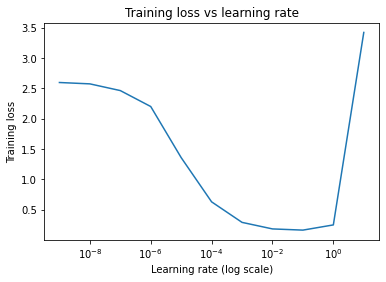

In [17]:
# plt.figure(figsize=(12,6))
plt.semilogx(lrs, train_losses)
plt.title("Training loss vs learning rate")
plt.xlabel('Learning rate (log scale)')
plt.ylabel('Training loss')
plt.show()

From the plot below, we can see that the loss starts decreasing before around 1e-5 and starts to saturate around 1e-1. So, we can choose these two values as $lr_{min}$ and $lr_{max}$.

In [10]:
lrmin = 1e-5
lrmax = 1e-1

# Part 3

In [11]:
class CyclicLR(Callback):
    def __init__(self, base_lr=0.001, max_lr=0.006, step_size=2000., mode='triangular',
                 gamma=1., scale_fn=None, scale_mode='cycle'):
        super(CyclicLR, self).__init__()

        self.base_lr = base_lr
        self.max_lr = max_lr
        self.step_size = step_size
        self.mode = mode
        self.gamma = gamma
        if scale_fn == None:
            if self.mode == 'triangular':
                self.scale_fn = lambda x: 1.
                self.scale_mode = 'cycle'
            elif self.mode == 'triangular2':
                self.scale_fn = lambda x: 1/(2.**(x-1))
                self.scale_mode = 'cycle'
            elif self.mode == 'exp_range':
                self.scale_fn = lambda x: gamma**(x)
                self.scale_mode = 'iterations'
        else:
            self.scale_fn = scale_fn
            self.scale_mode = scale_mode
        self.clr_iterations = 0.
        self.trn_iterations = 0.
        self.history = {}

        self._reset()

    def _reset(self, new_base_lr=None, new_max_lr=None,
               new_step_size=None):
        """Resets cycle iterations.
        Optional boundary/step size adjustment.
        """
        if new_base_lr != None:
            self.base_lr = new_base_lr
        if new_max_lr != None:
            self.max_lr = new_max_lr
        if new_step_size != None:
            self.step_size = new_step_size
        self.clr_iterations = 0.
        
    def clr(self):
        cycle = np.floor(1+self.clr_iterations/(2*self.step_size))
        x = np.abs(self.clr_iterations/self.step_size - 2*cycle + 1)
        if self.scale_mode == 'cycle':
            return self.base_lr + (self.max_lr-self.base_lr)*np.maximum(0, (1-x))*self.scale_fn(cycle)
        else:
            return self.base_lr + (self.max_lr-self.base_lr)*np.maximum(0, (1-x))*self.scale_fn(self.clr_iterations)
        
    def on_train_begin(self, logs={}):
        logs = logs or {}

        if self.clr_iterations == 0:
            K.set_value(self.model.optimizer.lr, self.base_lr)
        else:
            K.set_value(self.model.optimizer.lr, self.clr())        
            
    def on_batch_end(self, epoch, logs=None):
        
        logs = logs or {}
        self.trn_iterations += 1
        self.clr_iterations += 1

        self.history.setdefault('lr', []).append(K.get_value(self.model.optimizer.lr))
        self.history.setdefault('iterations', []).append(self.trn_iterations)

        for k, v in logs.items():
            self.history.setdefault(k, []).append(v)
        
        K.set_value(self.model.optimizer.lr, self.clr())

In [12]:
clr = CyclicLR(base_lr=lrmin, max_lr=lrmax, mode='exp_range', step_size=4*(X_train.shape[0]//BATCH_SIZE))

In [13]:
opt = SGD(lr=lrmin, momentum=0.9)
model = MiniGoogLeNet.build(width=32, height=32, depth=1, classes=10)
model.compile(loss="categorical_crossentropy", optimizer=opt, metrics=["accuracy"])
H = model.fit(X_train,Y_train,epochs=30,validation_split=0.2,batch_size=BATCH_SIZE,
              steps_per_epoch=X_train.shape[0]//BATCH_SIZE,callbacks=[clr,EarlyStopping(min_delta=0.001,patience=3)],verbose=2)

Epoch 1/30
937/937 - 113s - loss: 0.6670 - accuracy: 0.7610 - val_loss: 1.0657 - val_accuracy: 0.7113
Epoch 2/30
937/937 - 98s - loss: 0.3304 - accuracy: 0.8827 - val_loss: 0.4678 - val_accuracy: 0.8423
Epoch 3/30
937/937 - 103s - loss: 0.2784 - accuracy: 0.8999 - val_loss: 0.3099 - val_accuracy: 0.8992
Epoch 4/30
937/937 - 100s - loss: 0.2429 - accuracy: 0.9149 - val_loss: 0.4182 - val_accuracy: 0.8770
Epoch 5/30
937/937 - 100s - loss: 0.1958 - accuracy: 0.9305 - val_loss: 0.2101 - val_accuracy: 0.9218
Epoch 6/30
937/937 - 100s - loss: 0.1502 - accuracy: 0.9463 - val_loss: 0.2374 - val_accuracy: 0.9243
Epoch 7/30
937/937 - 101s - loss: 0.1108 - accuracy: 0.9608 - val_loss: 0.2293 - val_accuracy: 0.9232
Epoch 8/30
937/937 - 102s - loss: 0.0650 - accuracy: 0.9772 - val_loss: 0.1800 - val_accuracy: 0.9429
Epoch 9/30
937/937 - 108s - loss: 0.0454 - accuracy: 0.9844 - val_loss: 0.2476 - val_accuracy: 0.9273
Epoch 10/30
937/937 - 104s - loss: 0.0744 - accuracy: 0.9730 - val_loss: 0.2838 - v

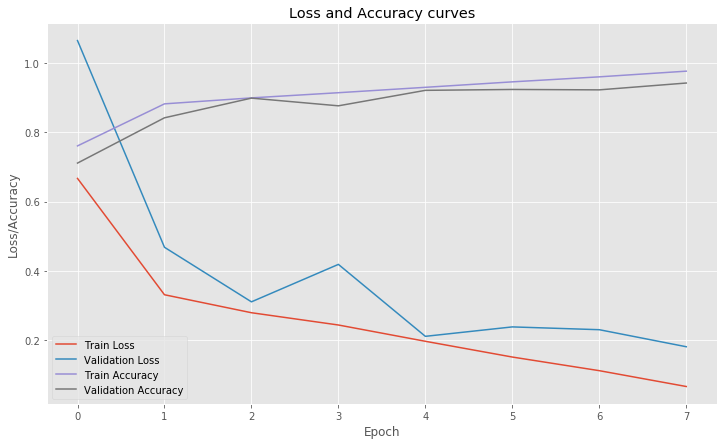

In [15]:
epochs = np.arange(0, 8)
plt.style.use("ggplot")
plt.figure()
plt.plot(epochs, H.history["loss"][:-3], label="Train Loss")
plt.plot(epochs, H.history["val_loss"][:-3], label="Validation Loss")
plt.plot(epochs, H.history["accuracy"][:-3], label="Train Accuracy")
plt.plot(epochs, H.history["val_accuracy"][:-3], label="Validation Accuracy")
plt.title("Loss and Accuracy curves")
plt.xlabel("Epoch")
plt.ylabel("Loss/Accuracy")
plt.legend()
# plt.ylim(0,5)
plt.show()

## 2.4

In [16]:
bsizes = [2**i for i in range(6,12)]
n_epoch_set = [5*b//64 for b in bsizes]
bsizes, n_epoch_set

([64, 128, 256, 512, 1024, 2048], [5, 10, 20, 40, 80, 160])

In [17]:
train_losses_bsizes = []
for i in range(len(bsizes[:2])):
    print("\nBatch size: ", bsizes[i])
    opt = SGD(lr=lrmin, momentum=0.9)
    model = MiniGoogLeNet.build(width=32, height=32, depth=1, classes=10)
    model.compile(loss="categorical_crossentropy", optimizer=opt, metrics=["accuracy"])
    H = model.fit(X_train,Y_train,epochs=n_epoch_set[i],validation_split=0.2,batch_size=bsizes[i],verbose=2)
    train_losses_bsizes.append(H.history['loss'][-1])


Batch size:  64
Epoch 1/5
750/750 - 80s - loss: 2.4463 - accuracy: 0.1356 - val_loss: 2.1171 - val_accuracy: 0.1972
Epoch 2/5
750/750 - 79s - loss: 2.1030 - accuracy: 0.2344 - val_loss: 1.8096 - val_accuracy: 0.4769
Epoch 3/5
750/750 - 80s - loss: 1.8768 - accuracy: 0.3384 - val_loss: 1.6154 - val_accuracy: 0.6198
Epoch 4/5
750/750 - 81s - loss: 1.7066 - accuracy: 0.4161 - val_loss: 1.4740 - val_accuracy: 0.6705
Epoch 5/5
750/750 - 83s - loss: 1.5706 - accuracy: 0.4685 - val_loss: 1.3616 - val_accuracy: 0.6910

Batch size:  128
Epoch 1/10
375/375 - 82s - loss: 2.4588 - accuracy: 0.1172 - val_loss: 2.4508 - val_accuracy: 0.0995
Epoch 2/10
375/375 - 77s - loss: 2.2135 - accuracy: 0.1855 - val_loss: 2.0029 - val_accuracy: 0.2806
Epoch 3/10
375/375 - 77s - loss: 2.0344 - accuracy: 0.2627 - val_loss: 1.8193 - val_accuracy: 0.4225
Epoch 4/10
375/375 - 76s - loss: 1.8999 - accuracy: 0.3172 - val_loss: 1.6999 - val_accuracy: 0.4909
Epoch 5/10
375/375 - 76s - loss: 1.7894 - accuracy: 0.3676 - 

In [18]:
print(train_losses_bsizes)

[1.5705708265304565, 1.4531182050704956]


In [19]:
for i in range(2,4):
    print("\nBatch size: ", bsizes[i])
    opt = SGD(lr=lrmin, momentum=0.9)
    model = MiniGoogLeNet.build(width=32, height=32, depth=1, classes=10)
    model.compile(loss="categorical_crossentropy", optimizer=opt, metrics=["accuracy"])
    H = model.fit(X_train,Y_train,epochs=n_epoch_set[i],validation_split=0.2,batch_size=bsizes[i],verbose=2)
    train_losses_bsizes.append(H.history['loss'][-1])


Batch size:  256
Epoch 1/20
188/188 - 75s - loss: 2.6087 - accuracy: 0.1045 - val_loss: 2.4360 - val_accuracy: 0.1003
Epoch 2/20
188/188 - 74s - loss: 2.4539 - accuracy: 0.1298 - val_loss: 2.4061 - val_accuracy: 0.1062
Epoch 3/20
188/188 - 74s - loss: 2.3222 - accuracy: 0.1609 - val_loss: 2.2721 - val_accuracy: 0.2036
Epoch 4/20
188/188 - 75s - loss: 2.2099 - accuracy: 0.1939 - val_loss: 2.0500 - val_accuracy: 0.2988
Epoch 5/20
188/188 - 75s - loss: 2.1152 - accuracy: 0.2276 - val_loss: 1.9304 - val_accuracy: 0.3708
Epoch 6/20
188/188 - 76s - loss: 2.0330 - accuracy: 0.2614 - val_loss: 1.8523 - val_accuracy: 0.4205
Epoch 7/20
188/188 - 79s - loss: 1.9602 - accuracy: 0.2922 - val_loss: 1.7843 - val_accuracy: 0.4529
Epoch 8/20
188/188 - 88s - loss: 1.8989 - accuracy: 0.3158 - val_loss: 1.7264 - val_accuracy: 0.4790
Epoch 9/20
188/188 - 78s - loss: 1.8428 - accuracy: 0.3406 - val_loss: 1.6737 - val_accuracy: 0.5065
Epoch 10/20
188/188 - 76s - loss: 1.7891 - accuracy: 0.3601 - val_loss: 1

In [20]:
print(train_losses_bsizes)

[1.5705708265304565, 1.4531182050704956, 1.4617187976837158, 1.466109037399292]


In [21]:
print("\nBatch size: ", bsizes[4])
opt = SGD(lr=lrmin, momentum=0.9)
model = MiniGoogLeNet.build(width=32, height=32, depth=1, classes=10)
model.compile(loss="categorical_crossentropy", optimizer=opt, metrics=["accuracy"])
H = model.fit(X_train,Y_train,epochs=n_epoch_set[i],validation_split=0.2,batch_size=bsizes[i],verbose=2)
train_losses_bsizes.append(H.history['loss'][-1])


Batch size:  1024
Epoch 1/40
94/94 - 69s - loss: 2.6878 - accuracy: 0.1036 - val_loss: 2.3906 - val_accuracy: 0.1005
Epoch 2/40
94/94 - 79s - loss: 2.6029 - accuracy: 0.1168 - val_loss: 2.5125 - val_accuracy: 0.1005
Epoch 3/40
94/94 - 85s - loss: 2.5211 - accuracy: 0.1321 - val_loss: 2.4737 - val_accuracy: 0.1005
Epoch 4/40
94/94 - 75s - loss: 2.4530 - accuracy: 0.1459 - val_loss: 2.3865 - val_accuracy: 0.1107
Epoch 5/40
94/94 - 73s - loss: 2.3923 - accuracy: 0.1618 - val_loss: 2.3555 - val_accuracy: 0.1182
Epoch 6/40
94/94 - 84s - loss: 2.3398 - accuracy: 0.1786 - val_loss: 2.3033 - val_accuracy: 0.1500
Epoch 7/40
94/94 - 77s - loss: 2.2888 - accuracy: 0.1929 - val_loss: 2.1987 - val_accuracy: 0.1759
Epoch 8/40
94/94 - 71s - loss: 2.2411 - accuracy: 0.2110 - val_loss: 2.0977 - val_accuracy: 0.2167
Epoch 9/40
94/94 - 70s - loss: 2.2001 - accuracy: 0.2228 - val_loss: 2.0339 - val_accuracy: 0.2600
Epoch 10/40
94/94 - 71s - loss: 2.1530 - accuracy: 0.2417 - val_loss: 1.9878 - val_accurac

In [22]:
print(train_losses_bsizes)

[1.5705708265304565, 1.4531182050704956, 1.4617187976837158, 1.466109037399292, 1.4693599939346313]


In [32]:

print("\nBatch size: ", bsizes[5])
opt = SGD(lr=lrmin, momentum=0.9)
model = MiniGoogLeNet.build(width=32, height=32, depth=1, classes=10)
model.compile(loss="categorical_crossentropy", optimizer=opt, metrics=["accuracy"])
H = model.fit(X_train,Y_train,epochs=n_epoch_set[i],validation_split=0.2,batch_size=bsizes[i],verbose=2)
train_losses_bsizes.append(H.history['loss'][-1])


Batch size:  2048
Epoch 1/40
94/94 - 67s - loss: 2.6671 - accuracy: 0.1065 - val_loss: 2.3459 - val_accuracy: 0.0983
Epoch 2/40
94/94 - 67s - loss: 2.5580 - accuracy: 0.1156 - val_loss: 2.4036 - val_accuracy: 0.1140
Epoch 3/40
94/94 - 68s - loss: 2.4727 - accuracy: 0.1307 - val_loss: 2.4159 - val_accuracy: 0.1320
Epoch 4/40
94/94 - 67s - loss: 2.3960 - accuracy: 0.1451 - val_loss: 2.3744 - val_accuracy: 0.1320
Epoch 5/40
94/94 - 67s - loss: 2.3302 - accuracy: 0.1636 - val_loss: 2.3138 - val_accuracy: 0.1495
Epoch 6/40
94/94 - 68s - loss: 2.2701 - accuracy: 0.1821 - val_loss: 2.2222 - val_accuracy: 0.1449
Epoch 7/40
94/94 - 72s - loss: 2.2204 - accuracy: 0.1991 - val_loss: 2.1222 - val_accuracy: 0.1462
Epoch 8/40
94/94 - 72s - loss: 2.1620 - accuracy: 0.2181 - val_loss: 2.0212 - val_accuracy: 0.2488
Epoch 9/40
94/94 - 69s - loss: 2.1145 - accuracy: 0.2392 - val_loss: 1.9569 - val_accuracy: 0.3229
Epoch 10/40
94/94 - 68s - loss: 2.0736 - accuracy: 0.2559 - val_loss: 1.9090 - val_accurac

In [ ]:

print("\nBatch size: ", bsizes[5])
opt = SGD(lr=lrmin, momentum=0.9)
model = MiniGoogLeNet.build(width=32, height=32, depth=1, classes=10)
model.compile(loss="categorical_crossentropy", optimizer=opt, metrics=["accuracy"])
H = model.fit(X_train,Y_train,epochs=n_epoch_set[i],validation_split=0.2,batch_size=bsizes[i],verbose=2)
train_losses_bsizes.append(H.history['loss'][-1])

In [24]:
print(train_losses_bsizes)

[1.5705708265304565, 1.4531182050704956, 1.4617187976837158, 1.466109037399292, 1.4693599939346313, 1.4488837718963623]


In [25]:
# Prepare the training dataset.
batch_size = 512
train_dataset = tf.data.Dataset.from_tensor_slices((X_train, Y_train))
train_dataset = train_dataset.shuffle(buffer_size=1024).batch(batch_size)

# Prepare the validation dataset.
val_dataset = tf.data.Dataset.from_tensor_slices((X_test, Y_test))
val_dataset = val_dataset.batch(batch_size)

In [30]:
loss_fn = tf.keras.losses.CategoricalCrossentropy()
optimizer = SGD(lr=lrmin, momentum=0.9)
model = MiniGoogLeNet.build(width=32, height=32, depth=1, classes=10)
epochs = 320
print("Batch size: 4096")
for epoch in range(epochs):
    print("\nEpoch: {}/{}".format(epoch+1, epochs))
    loss_value = 0
    total_loss = 0
    # Iterate over the batches of the dataset.
    for step, (x_batch_train, y_batch_train) in tqdm(enumerate(train_dataset)):
        # Open a GradientTape to record the operations run
        # during the forward pass, which enables auto-differentiation.
        with tf.GradientTape() as tape:

            # Run the forward pass of the layer.
            # The operations that the layer applies
            # to its inputs are going to be recorded
            # on the GradientTape.
            y_batch_pred = model(x_batch_train, training=True)  # Logits for this minibatch

            # Compute the loss value for this minibatch.
            total_loss += loss_fn(y_batch_train, y_batch_pred).numpy()
            loss_value += loss_fn(y_batch_train, y_batch_pred)

        # Use the gradient tape to automatically retrieve
        # the gradients of the trainable variables with respect to the loss.
        if step != 0 and step % 8 == 0:
            grads = tape.gradient(loss_value, model.trainable_weights)

            # Run one step of gradient descent by updating
            # the value of the variables to minimize the loss.
            optimizer.apply_gradients(zip(grads, model.trainable_weights))
            loss_value = 0
    print("Loss: ", float(total_loss/len(train_dataset)))
# train_losses_bsizes.append(float(total_loss/len(train_dataset)))
        # if step % 200 == 0:
        #     print(
        #         "Training loss (for one batch) at step %d: %.4f"
        #         % (step, float(loss_value))
        #     )
        #     print("Seen so far: %s samples" % ((step + 1) * batch_size))

Batch size: 4096

Epoch: 1/320


ImportError: FloatProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html

In [ ]:
train_losses_bsizes.append(float(total_loss/len(train_dataset)))

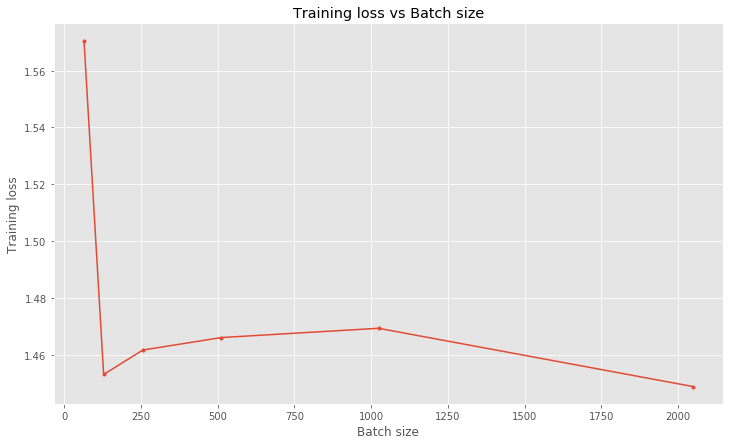

In [43]:
plt.plot(bsizes, train_losses_bsizes[:6], marker='.')
plt.title('Training loss vs Batch size')
plt.xlabel('Batch size')
plt.ylabel('Training loss')
plt.show()

# 2.4,2.5 
From batch size=64 to 128 we see a clear drop in loss. From 128 to 2048 the loss almost remains the same. We then expect it to increase which is similar to the curve obsereved for learning rates. Therefore we choose $b_{min} = 128$ and $b_{max} = 2048$

# 2.6

We exponentially decrease the batch size for the cyclical batch size policy as was done in the case with cyclic learning rate.

In [44]:
class LearningRateFinder:
    def __init__(self, model, stopFactor=4, beta=0.98):
        # store the model, stop factor, and beta value (for computing
        # a smoothed, average loss)
        self.model = model
        self.stopFactor = stopFactor
        self.beta = beta
        # initialize our list of learning rates and losses,
        # respectively
        self.lrs = []
        self.losses = []
        # initialize our learning rate multiplier, average loss, best
        # loss found thus far, current batch number, and weights file
        self.lrMult = 1
        self.avgLoss = 0
        self.bestLoss = 1e9
        self.batchNum = 0
        self.weightsFile = None

    def reset(self):
        # re-initialize all variables from our constructor
        self.lrs = []
        self.losses = []
        self.lrMult = 1
        self.avgLoss = 0
        self.bestLoss = 1e9
        self.batchNum = 0
        self.weightsFile = None

    def is_data_iter(self, data):
        # define the set of class types we will check for
        iterClasses = ["NumpyArrayIterator", "DirectoryIterator",
            "DataFrameIterator", "Iterator", "Sequence"]
        # return whether our data is an iterator
        return data.__class__.__name__ in iterClasses

    def on_batch_end(self, batch, logs):
        # grab the current learning rate and add log it to the list of
        # learning rates that we've tried
        lr = K.get_value(self.model.optimizer.lr)
        self.lrs.append(lr)
        # grab the loss at the end of this batch, increment the total
        # number of batches processed, compute the average average
        # loss, smooth it, and update the losses list with the
        # smoothed value
        l = logs["loss"]
        self.batchNum += 1
        self.avgLoss = (self.beta * self.avgLoss) + ((1 - self.beta) * l)
        smooth = self.avgLoss / (1 - (self.beta ** self.batchNum))
        self.losses.append(smooth)
        # compute the maximum loss stopping factor value
        stopLoss = self.stopFactor * self.bestLoss
        # check to see whether the loss has grown too large
        if self.batchNum > 1 and smooth > stopLoss:
            # stop returning and return from the method
            self.model.stop_training = True
            return
        # check to see if the best loss should be updated
        if self.batchNum == 1 or smooth < self.bestLoss:
            self.bestLoss = smooth
        # increase the learning rate
        lr *= self.lrMult
        K.set_value(self.model.optimizer.lr, lr)
  
    def find(self, trainData, startLR, endLR, epochs=None,
        stepsPerEpoch=None, batchSize=32, sampleSize=2048,
        verbose=1):
        # reset our class-specific variables
        self.reset()
        # determine if we are using a data generator or not
        useGen = self.is_data_iter(trainData)
        # if we're using a generator and the steps per epoch is not
        # supplied, raise an error
        if useGen and stepsPerEpoch is None:
            msg = "Using generator without supplying stepsPerEpoch"
            raise Exception(msg)
        # if we're not using a generator then our entire dataset must
        # already be in memory
        elif not useGen:
            # grab the number of samples in the training data and
            # then derive the number of steps per epoch
            numSamples = len(trainData[0])
            stepsPerEpoch = np.ceil(numSamples / float(batchSize))
        # if no number of training epochs are supplied, compute the
        # training epochs based on a default sample size
        if epochs is None:
            epochs = int(np.ceil(sampleSize / float(stepsPerEpoch)))
   
        # compute the total number of batch updates that will take
        # place while we are attempting to find a good starting
        # learning rate
        numBatchUpdates = epochs * stepsPerEpoch
        # derive the learning rate multiplier based on the ending
        # learning rate, starting learning rate, and total number of
        # batch updates
        self.lrMult = (endLR / startLR) ** (1.0 / numBatchUpdates)
        # create a temporary file path for the model weights and
        # then save the weights (so we can reset the weights when we
        # are done)
        self.weightsFile = tempfile.mkstemp()[1]
        self.model.save_weights(self.weightsFile)
        # grab the *original* learning rate (so we can reset it
        # later), and then set the *starting* learning rate
        origLR = K.get_value(self.model.optimizer.lr)
        K.set_value(self.model.optimizer.lr, startLR)

        # construct a callback that will be called at the end of each
        # batch, enabling us to increase our learning rate as training
        # progresses
        callback = LambdaCallback(on_batch_end=lambda batch, logs:
            self.on_batch_end(batch, logs))
        # check to see if we are using a data iterator
        if useGen:
            self.model.fit(
                x=trainData,
                steps_per_epoch=stepsPerEpoch,
                epochs=epochs,
                verbose=verbose,
                callbacks=[callback])
        # otherwise, our entire training data is already in memory
        else:
            # train our model using Keras' fit method
            self.model.fit(
                x=trainData[0], y=trainData[1],
                batch_size=batchSize,
                epochs=epochs,
                callbacks=[callback],
                verbose=verbose)
        # restore the original model weights and learning rate
        self.model.load_weights(self.weightsFile)
        K.set_value(self.model.optimizer.lr, origLR)

    def plot_loss(self, skipBegin=10, skipEnd=1, title=""):
        # grab the learning rate and losses values to plot
        lrs = self.lrs[skipBegin:-skipEnd]
        losses = self.losses[skipBegin:-skipEnd]
        # plot the learning rate vs. loss
        plt.plot(lrs, losses)
        plt.xscale("log")
        plt.xlabel("Learning Rate (Log Scale)")
        plt.ylabel("Loss")
        # if the title is not empty, add it to the plot
        if title != "":
            plt.title(title)  

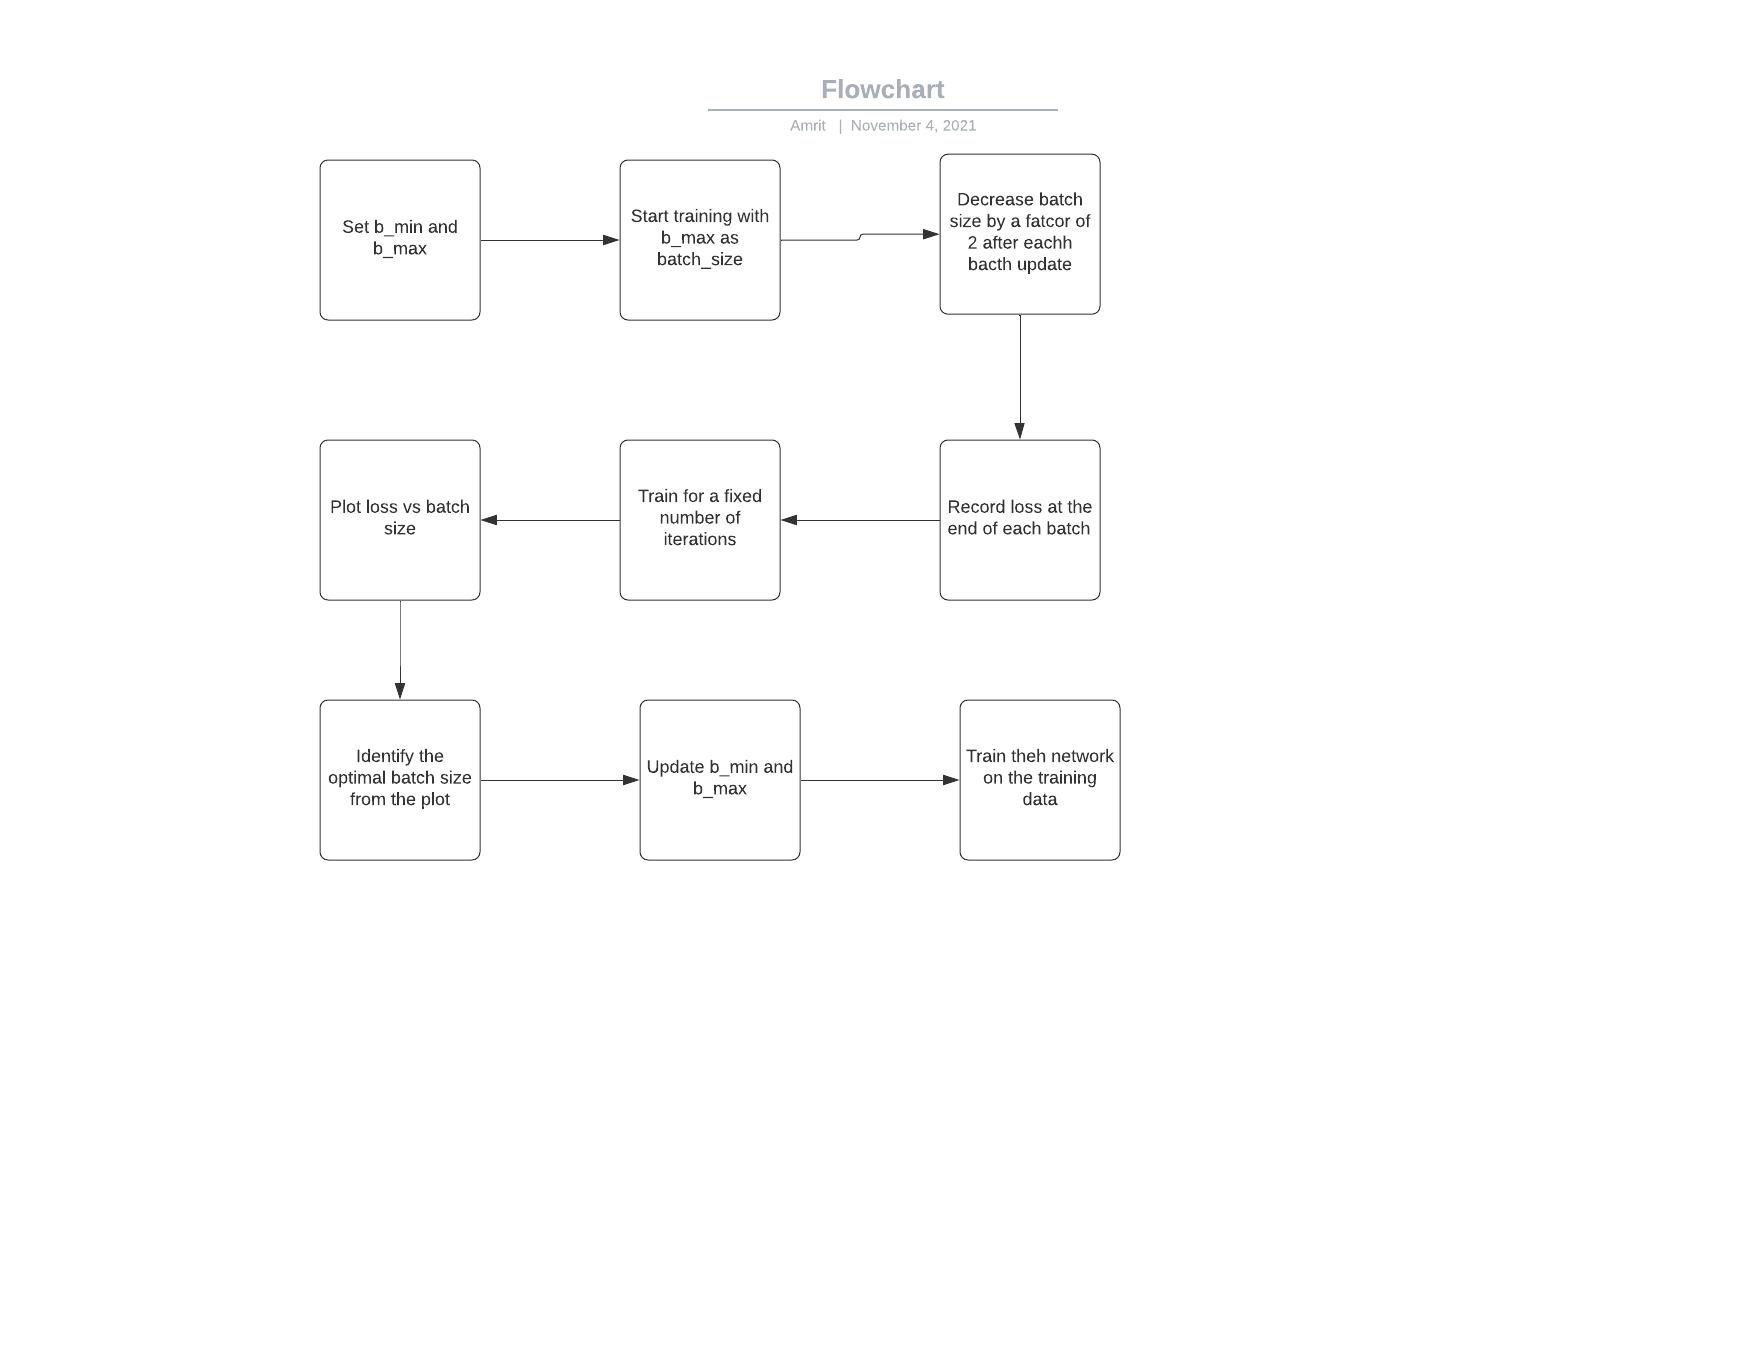

2.6  We can train the model using the following steps -
-Set small and large batch size bounds. \\
-Train network \\
-Decrease batch size in multiples of 2 after each update. \\
-Record loss & batch size at the end, train for fixed iterations \\
-Plot loss & batch size \\
-Examine plot and identify the optimal batch size \\
-Update the batch sizes \\
-Train network on full set of data \\

2.7 The cyclical learning rate policy gives a better accuracy when compared to the cyclical batch size policy.